# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Reframing the Business Task as a Data Problem

From a business perspective, the goal is to identify the key drivers of used car prices. This can be reframed into a data science problem as follows:

"We aim to develop a predictive model that quantifies the relationship between car attributes (e.g., age, mileage, condition, drivetrain, etc.) and price. By analyzing feature importance and correlations, we will identify the most influential factors affecting used car prices. Additionally, we will use statistical and machine learning techniques to uncover patterns and trends in the data, enabling actionable insights for pricing strategies in the used car market."


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

To get familiar with the dataset and identify any quality issues, we would take the following steps:

## Initial Data Exploration

1. **Examine Dataset Structure**: Review the first few rows of the dataset to understand its structure and the information it contains.

2. **Assess Data Completeness**: Check for missing values in each column to identify potential data gaps.

3. **Analyze Data Types**: Examine the data types of each column to ensure they align with expectations and identify any necessary type conversions.

4. **Generate Descriptive Statistics**: Calculate basic statistics (mean, median, min, max, standard deviation) for numerical columns to gain insights into the data distribution.

## Data Quality Assessment

5. **Identify Duplicates**: Check for and quantify any duplicate rows in the dataset.

6. **Detect Outliers**: Use statistical methods or visualizations like boxplots to identify outliers in numerical columns, particularly for price and odometer readings.

7. **Review Categorical Data**: Examine unique values in categorical columns (e.g., manufacturer, model, condition) to spot inconsistencies or unexpected entries.

## In-depth Analysis

8. **Analyze Price Distribution**: Create histograms or density plots to visualize the distribution of car prices.

9. **Explore Relationships**: Generate scatter plots or correlation matrices to understand relationships between numerical variables (e.g., price vs. year, price vs. odometer).

10. **Categorical Analysis**: Use bar charts to visualize the frequency of different categories (e.g., most common manufacturers, models, or fuel types).

11. **Geographical Insights**: If applicable, create maps or regional summaries to understand geographical patterns in car prices or availability.

12. **Temporal Trends**: Analyze how car prices vary based on the year of manufacture or listing date.

## Data Quality Improvements

13. **Handle Missing Data**: Develop strategies for dealing with missing values, such as imputation or removal.

14. **Standardize Categories**: Address any inconsistencies in categorical data, such as different spellings or capitalization.

15. **Outlier Treatment**: Decide on appropriate methods for handling outliers, whether through removal, transformation, or separate analysis.

By following these steps, we can gain a comprehensive understanding of the dataset, identify potential quality issues, and prepare the data for further analysis. This process will inform our business understanding by revealing patterns, trends, and potential factors influencing used car prices, ultimately supporting the goal of providing valuable insights to the used car dealership.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [31]:
import time
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, 
                                   OrdinalEncoder, FunctionTransformer)
from sklearn.model_selection import (train_test_split, KFold, 
                                     RandomizedSearchCV)
from sklearn.metrics import (r2_score, mean_absolute_error, 
                             mean_squared_error)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Load the dataset
data = pd.read_csv('data/vehicles.csv')


# display  all columns.
pd.set_option('display.max_columns', None)
data.head()
# print(data.shape)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [33]:
# --- DATA CLEANING ---
# Convert price to numeric and filter valid prices
data['price'] = pd.to_numeric(data['price'], errors='coerce')
data = data[(data['price'] >= 1000) & (data['price'] <= 100000)]

# Convert year to numeric
data['year'] = pd.to_numeric(data['year'], errors='coerce')
data['odometer'] = pd.to_numeric(data['odometer'], errors='coerce')

# Replace missing fuel values with "unknown" (if any)
data['fuel'] = data['fuel'].fillna('unknown')

# Replace missing transmission values with "unknown"
data['transmission'] = data['transmission'].fillna('unknown')

# Replace missing drive values with "unknown_drive"
data['drive'] = data['drive'].fillna('unknown_drive')

# Handle odometer outliers
Q1 = data['odometer'].quantile(0.25)
Q3 = data['odometer'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['odometer'] < (Q1 - 1.5 * IQR)) | 
              (data['odometer'] > (Q3 + 1.5 * IQR)))]

# --- FEATURE ENGINEERING ---
current_year = datetime.now().year
data['age'] = np.where(data['year'] > current_year, 0, current_year - data['year'])

# luxury brands list
luxury_brands = ['bmw', 'mercedes-benz', 'audi', 'lexus', 'porsche', 
                 'cadillac', 'jaguar', 'land rover', 'infiniti', 'tesla', 
                 'maserati', 'lincoln']
data['is_luxury'] = data['manufacturer'].str.lower().isin(luxury_brands).astype(int)

# Condition mapping
condition_order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
data['condition'] = data['condition'].str.lower().fillna('unknown')
data['condition'] = np.where(data['condition'].isin(condition_order),
                            data['condition'], 'unknown')

# Cylinders processing
data['cylinders'] = (
    data['cylinders']
    .astype(str)  # Convert to string type first
    .str.extract(r'(\d+)')  # Extract numeric values
    .astype(float)
)
data['cylinders'] = data['cylinders'].fillna(data.groupby('type')['cylinders'].transform('median'))

# Title status processing. Drop 'parts only' and 'missing' statuses
statuses_to_drop = ['parts only', 'missing']
data = data[~data['title_status'].isin(statuses_to_drop)]

# Group states with fewer than 1,000 rows into "other" to prevent overfitting
state_counts = data['state'].value_counts()
low_freq_states = state_counts[state_counts < 1000].index
data['state'] = data['state'].replace(low_freq_states, 'other')

# Since a large dataset of drive has unknown values lets try to fill them based on the type of vehicle
# Define a mapping of common drive types by vehicle type
type_to_drive = {
    'truck': '4wd',
    'suv': '4wd',
    'sedan': 'fwd',
    'coupe': 'rwd',
    'van': 'fwd',
    'hatchback': 'fwd',
    'convertible': 'rwd',
    'mini-van': 'fwd',
    'wagon': 'fwd',
    'offroad': '4wd',
    'bus': 'rwd',
    'pickup': '4wd',  # Added mapping for "pickup"
    'other': 'unknown_drive'  # Default for ambiguous types
}

# Impute missing drive values based on vehicle type
data['drive'] = data.apply(
    lambda row: type_to_drive[row['type'].lower()] if row['drive'] == 'unknown_drive' and pd.notnull(row['type']) else row['drive'],
    axis=1
)

# Define a mapping of manufacturers/models to drive types
model_to_drive = {
    'rav4': 'fwd',  # Toyota RAV4 is typically FWD or AWD
    'charger limousine': 'rwd',  # Dodge Charger Limousine is likely RWD
    'focus': 'fwd',  # Ford Focus is typically FWD
    'windstar': 'fwd',  # Ford Windstar is typically FWD
    'sport trac': '4wd',  # Ford Sport Trac is often 4WD
    'f150': '4wd',  # Ford F-150 is often 4WD
    'x6': '4wd',  # BMW X6 is typically AWD,
    'plymouth voyager': 'fwd',  # Plymouth Voyager is typically FWD
}

# Impute missing drive values based on model
data['drive'] = data.apply(
    lambda row: model_to_drive[row['model'].lower()]
    if row['drive'] == 'unknown_drive' and pd.notnull(row['model']) and row['model'].lower() in model_to_drive
    else row['drive'],
    axis=1
)

# Mapping of manufacturers/models to drive types since most vehicles from the same manufacturer have the same drive type
manufacturer_to_drive = {
    'jaguar': '4wd',  # Most Jaguar vehicles are all-wheel drive
    'buick': 'fwd',   # Buick models are typically front-wheel drive
    'audi': '4wd',    # Audi vehicles often have Quattro AWD
    'acura': '4wd',   # Acura SUVs like MDX are often AWD
    'volvo': '4wd',    # Volvo vehicles are commonly AWD
    'cadillac': '4wd',  # Cadillac SUVs like Escalade are often AWD
    'lexus': '4wd',    # Lexus vehicles are often AWD
    'lincoln': '4wd',  # Lincoln SUVs like Navigator are often AWD
    'infiniti': '4wd',  # Infiniti vehicles are often AWD
    'mercedes-benz': '4wd',  # Mercedes-Benz vehicles are often AWD
    'subaru': '4wd',  # Subaru vehicles are all-wheel drive
    'porsche': '4wd',  # Porsche vehicles are often AWD
    'land rover': '4wd',  # Land Rover vehicles are all-wheel drive
    'jeep': '4wd',  # Jeep vehicles are often 4WD
    'gmc': '4wd',  # GMC vehicles are often 4WD
    'dodge': 'rwd',  # Dodge vehicles are often RWD
    'ram': '4wd',  # Ram trucks are often 4WD
    'chevrolet': 'fwd',  # Chevrolet cars are typically FWD
    'ford': 'fwd',  # Ford cars are typically FWD
    'toyota': 'fwd',  # Toyota cars are typically FWD
    'honda': 'fwd',  # Honda cars are typically FWD
    'nissan': 'fwd',  # Nissan cars are typically FWD
    'volkswagen': 'fwd',  # Volkswagen cars are typically FWD
    'kia': 'fwd',  # Kia cars are typically FWD
    'hyundai': 'fwd',  # Hyundai cars are typically FWD
    'mazda': 'fwd',  # Mazda cars are typically FWD
    'mitsubishi': 'fwd',  # Mitsubishi cars are typically FWD
    'subaru': '4wd',  # Subaru vehicles are all-wheel drive
    'mini': 'fwd',  # Mini cars are typically FWD
    'fiat': 'fwd',  # Fiat cars are typically FWD
    'chrysler': 'fwd',  # Chrysler cars are typically FWD,
    'bmw': 'rwd',  # BMW vehicles are typically RWD,
    'mercury': 'fwd',  # Mercury cars are typically FWD,
    'tesla': '4wd',  # Tesla vehicles are often AWD
    'pontiac': 'fwd',  # Pontiac cars are typically FWD
}

# Impute missing drive values based on manufacturer
data['drive'] = data.apply(
    lambda row: manufacturer_to_drive[row['manufacturer'].lower()]
    if row['drive'] == 'unknown_drive' and pd.notnull(row['manufacturer']) and row['manufacturer'].lower() in manufacturer_to_drive
    else row['drive'],
    axis=1
)


# Drop remaining rows with missing values
# Drop rows where 'manufacturer', 'model', and 'type' are all missing
data = data[~(data['manufacturer'].isna() & data['model'].isna() & data['type'].isna())]

print(data.shape)

(375587, 20)


In [34]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,age,is_luxury
27,7316814884,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8.0,gas,57923.0,clean,other,3GTP1VEC4EG551563,4wd,NaN,pickup,white,al,11.0,0
28,7316814758,auburn,22590,2010.0,chevrolet,silverado 1500,good,8.0,gas,71229.0,clean,other,1GCSCSE06AZ123805,4wd,NaN,pickup,blue,al,15.0,0
29,7316814989,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8.0,gas,19160.0,clean,other,3GCPWCED5LG130317,4wd,NaN,pickup,red,al,5.0,0
30,7316743432,auburn,30990,2017.0,toyota,tundra double cab sr,good,8.0,gas,41124.0,clean,other,5TFRM5F17HX120972,4wd,NaN,pickup,red,al,8.0,0
31,7316356412,auburn,15000,2013.0,ford,f-150 xlt,excellent,6.0,gas,128000.0,clean,automatic,NaN,rwd,full-size,truck,black,al,12.0,0


In [35]:
# --- PREPROCESSING ---
numeric_features = ['age', 'odometer', 'cylinders', 'is_luxury']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['manufacturer', 'fuel', 'transmission', 'drive', 'type', 'state', 'condition', 'title_status', 'paint_color']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [38]:
# --- DATA PREPARATION ---
X = data.drop(columns=['price'])
y = np.log1p(data['price'])  # Log-transform target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Hyperparameter grid for Random Forest
param_dist_rf = {
    'n_estimators': [50,100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Sample a subset of the data (e.g., 50,000 rows) to make training faster
data_sampled = data.sample(n=50000, random_state=42)

# Redefine target and features for the sampled data
y_sampled = np.log1p(data_sampled['price'])
X_sampled = data_sampled.drop(columns=['price'])

# Split sampled data
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42
)

# Preprocess sampled data
X_train_preprocessed_sampled = preprocessor.fit_transform(X_train_sampled)
X_test_preprocessed_sampled = preprocessor.transform(X_test_sampled)


# Randomized Search for Random Forest
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=10,  # Number of parameter settings to sample
    scoring='r2',
    cv=2,
    verbose=1,
    random_state=42
)

start_time = time.time()

# Fit the randomized search on preprocessed training data
random_search_rf.fit(X_train_preprocessed_sampled, y_train_sampled)

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Best parameters and score
print("Best Parameters for Random Forest:", random_search_rf.best_params_)
print("Best R² Score for Random Forest:", random_search_rf.best_score_)

# --- DEFINE MODELS ---
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

param_grids = {
    'Ridge Regression': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso Regression': {'alpha': [0.01, 0.1, 1.0]},
    'Random Forest': param_dist_rf
}

results = {}


for name, model in models.items():
    print(f"Training {name}...")
    
    if name in param_grids:
        # Use RandomizedSearchCV if hyperparameters are defined
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[name],
            n_iter=5,
            scoring='r2',
            cv=2,
            verbose=1,
            random_state=42
        )
        search.fit(X_train_preprocessed, y_train)
        best_model = search.best_estimator_
        print(f"Best Parameters for {name}: {search.best_params_}")
    else:
        # Train without hyperparameter tuning
        model.fit(X_train_preprocessed, y_train)
        best_model = model
    
    # Predict on test data
    y_pred = best_model.predict(X_test_preprocessed)
    
    # Reverse log transformation (if applicable)
    y_pred_original_scale = np.expm1(y_pred)
    y_test_original_scale = np.expm1(y_test)
    
    # Evaluate the model
    results[name] = {
        'R² Score': r2_score(y_test, y_pred),
        'MAE (Original Scale)': mean_absolute_error(y_test_original_scale, y_pred_original_scale),
        'MSE (Original Scale)': mean_squared_error(y_test_original_scale, y_pred_original_scale)
    }

# Display results for all models
results_df = pd.DataFrame(results).T
print(results_df)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Time taken: 701.65 seconds
Best Parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best R² Score for Random Forest: 0.7873142484598368
Training Linear Regression...
Training Ridge Regression...
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/home/sohanit/Assignment2/new_env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for Ridge Regression: {'alpha': 1.0}
Training Lasso Regression...
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/home/sohanit/Assignment2/new_env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for Lasso Regression: {'alpha': 0.01}
Training Random Forest...
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
                   R² Score  MAE (Original Scale)  MSE (Original Scale)
Linear Regression  0.655013           5716.483099          7.982030e+07
Ridge Regression   0.655002           5716.649361          7.980776e+07
Lasso Regression   0.604014           5987.034937          8.340901e+07
Random Forest      0.850034           2873.768194          2.784813e+07


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client

In [15]:
# Feature importance
importances = random_search_rf.best_estimator_.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))  # Top 10 important features


                      Feature  Importance
0                    num__age    0.491352
1               num__odometer    0.145947
56             cat__drive_fwd    0.074073
2              num__cylinders    0.051294
45           cat__fuel_diesel    0.051132
119       cat__condition_fair    0.012702
3              num__is_luxury    0.010127
120       cat__condition_good    0.007693
42   cat__manufacturer_toyota    0.006766
68            cat__type_sedan    0.006532


The feature importance results indicate which features had the most influence on the predictions of your **Random Forest model**. Here's an analysis of the top features and their implications:

---

### **Feature Importance Analysis**

| Rank | Feature                  | Importance | Description/Implications                                                                 |
|------|--------------------------|------------|-----------------------------------------------------------------------------------------|
| 1    | `num__age`               | 0.491      | **Age** is the most important feature, as newer cars generally have higher resale value. |
| 2    | `num__odometer`          | 0.146      | **Mileage** is the second most important factor, as higher mileage typically reduces price. |
| 3    | `cat__drive_fwd`         | 0.074      | Cars with **front-wheel drive (FWD)** are common and may influence pricing differently than other drivetrains. |
| 4    | `num__cylinders`         | 0.051      | The number of **cylinders** affects engine size and performance, impacting price.         |
| 5    | `cat__fuel_diesel`       | 0.051      | Diesel vehicles often have niche demand and can command higher prices for specific buyers. |
| 6    | `cat__condition_fair`    | 0.013      | Cars in **fair condition** are priced lower than those in better condition.               |
| 7    | `num__is_luxury`         | 0.010      | Luxury cars have a premium value, though this feature has relatively low importance here. |
| 8    | `cat__condition_good`    | 0.008      | Cars in **good condition** are priced higher than those in fair condition but lower than excellent ones. |
| 9    | `cat__manufacturer_toyota`| 0.007     | Toyota vehicles have significant market share and resale value, influencing price trends. |
| 10   | `cat__type_sedan`        | 0.007      | Sedans are a common car type, and their pricing dynamics depend on demand and supply.     |

---

### **Key Observations**

1. **Dominance of Age and Mileage**:
   - The top two features (`age` and `odometer`) account for over **63% of total importance**, which aligns with industry trends where newer cars with lower mileage fetch higher prices.

2. **Drivetrain (`drive_fwd`)**:
   - The drivetrain (`drive_fwd`) plays a significant role, likely because front-wheel drive vehicles are more common and affordable compared to all-wheel drive (AWD) or rear-wheel drive (RWD).

3. **Engine Characteristics (`cylinders`, `fuel_diesel`)**:
   - Engine size (number of cylinders) and fuel type (diesel vs gas) influence pricing due to performance, fuel efficiency, and niche demand for diesel vehicles.

4. **Condition Matters**:
   - Vehicle condition (`fair`, `good`) impacts price but has less importance compared to age or mileage.

5. **Luxury Indicator (`is_luxury`)**:
   - While luxury branding is important, its relatively low importance here suggests that other factors like age and mileage dominate pricing decisions.

6. **Manufacturer Influence (`manufacturer_toyota`)**:
   - Toyota's strong resale value is reflected in its importance as a feature.

7. **Body Type (`type_sedan`)**:
   - Sedans are a common body type, but their influence on price is relatively small compared to other factors.



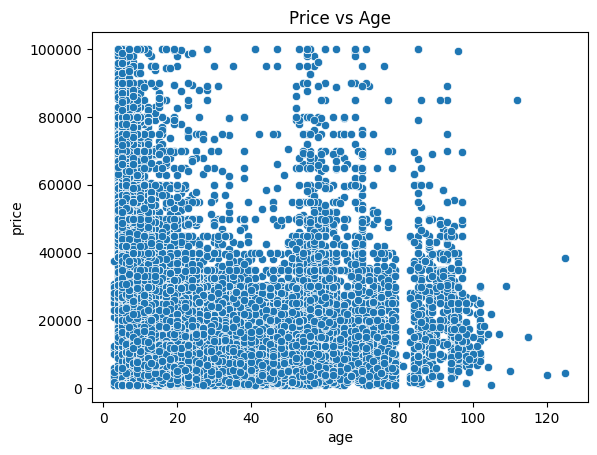

In [ ]:
# Age Vs Price 
sns.scatterplot(x=data['age'], y=data['price'])
plt.title('Price vs Age')
plt.show()


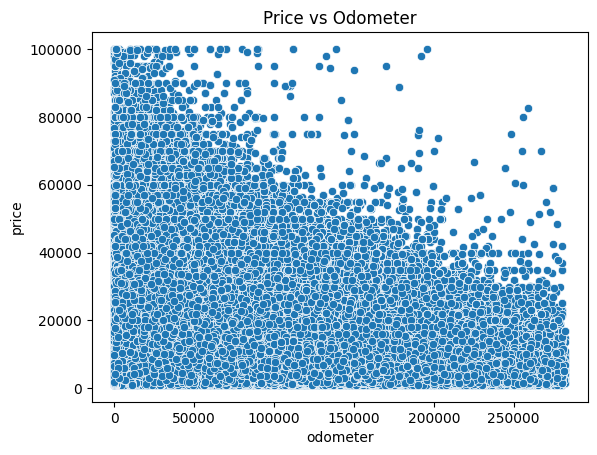

In [18]:
# Odometer Vs Price
sns.scatterplot(x=data['odometer'], y=data['price'])
plt.title('Price vs Odometer')
plt.show()

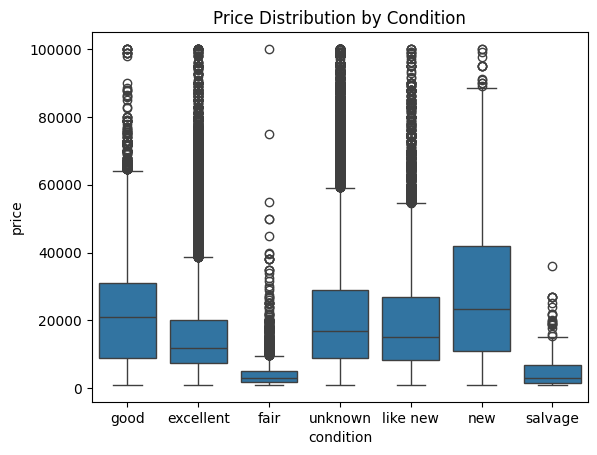

In [19]:
# Condition Vs Price
sns.boxplot(x=data['condition'], y=data['price'])
plt.title('Price Distribution by Condition')
plt.show()
